In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import models, layers
from keras.layers import Dense, LSTM, Dropout,Flatten
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential


In [39]:
df = pd.read_excel("sh_index2.xlsx")

df.timestamp=pd.to_datetime(df.date,format='%Y-%m-%d')
df.index=df.timestamp
df.drop('date',axis = 1, inplace = True)
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2935 entries, 2011-01-03 to 2022-04-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2935 non-null   float64
 1   high    2935 non-null   float64
 2   low     2935 non-null   float64
 3   close   2935 non-null   float64
 4   no      2935 non-null   float64
dtypes: float64(5)
memory usage: 137.6 KB


<ipython-input-39-9341a1cae222>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.timestamp=pd.to_datetime(df.date,format='%Y-%m-%d')


In [40]:
#df = df.resample('B').interpolate('linear') 
#df.to_csv('工作日线性插值上证指数.csv')

In [41]:
df.count()

open     2935
high     2935
low      2935
close    2935
no       2935
dtype: int64

In [42]:
train_set = df[:2400].iloc[:,0:]
validation_set = df[2400:2748].iloc[:,0:]
train_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2400 entries, 2011-01-03 to 2020-03-13
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2400 non-null   float64
 1   high    2400 non-null   float64
 2   low     2400 non-null   float64
 3   close   2400 non-null   float64
 4   no      2400 non-null   float64
dtypes: float64(5)
memory usage: 112.5 KB


In [74]:
#timestep=7
test_set_s = df[2748:2770].iloc[:,0:]
test_set_m30 = df[2748:2785].iloc[:,0:]
test_set_m60 = df[2748:2815].iloc[:,0:]
test_set_l = df[2748:].iloc[:,0:]
print(len(test_set_m30))
print(len(test_set_m60))
print(len(test_set_l))

37
67
187


In [75]:
#timestep=15
'''
test_set_s = df[2894:2924].iloc[:,0:]
test_set_m30 = df[2894:2939].iloc[:,0:]
test_set_m60 = df[2894:2969].iloc[:,0:]
test_set_l = df[2894:].iloc[:,0:]
print(len(test_set_s))
print(len(test_set_m60))
print(len(test_set_l))
'''

'\ntest_set_s = df[2894:2924].iloc[:,0:]\ntest_set_m30 = df[2894:2939].iloc[:,0:]\ntest_set_m60 = df[2894:2969].iloc[:,0:]\ntest_set_l = df[2894:].iloc[:,0:]\nprint(len(test_set_s))\nprint(len(test_set_m60))\nprint(len(test_set_l))\n'

In [76]:
scaler = MinMaxScaler(feature_range = (0,1))#数据的归一化，帮助模型拟合的更快
train_scaled_data = scaler.fit_transform(train_set)
validation_scaled_data = scaler.fit_transform(validation_set)


In [77]:
#预测15天测试集
test_scaled_data_s = scaler.fit_transform(test_set_s)
y_test_s_scaled_data = scaler.fit_transform(np.array(test_set_s['close']).reshape(-1,1))
#预测30天测试集
test_scaled_data_m30 = scaler.fit_transform(test_set_m30)
y_test_m30_scaled_data = scaler.fit_transform(np.array(test_set_m30['close']).reshape(-1,1))
#预测60天测试集
test_scaled_data_m60 = scaler.fit_transform(test_set_m60)
y_test_m60_scaled_data = scaler.fit_transform(np.array(test_set_m60['close']).reshape(-1,1))
#预测180天测试集
test_scaled_data_l = scaler.fit_transform(test_set_l)
y_test_l_scaled_data = scaler.fit_transform(np.array(test_set_l['close']).reshape(-1,1))
print(len(y_test_s_scaled_data))
print(len(test_scaled_data_m30))
print(len(test_scaled_data_m60))
print(len(test_scaled_data_l))

22
37
67
187


In [78]:
time_steps = 7

In [79]:
x_train, y_train = [],[]
for i in range(time_steps, len(train_set)):
    x_train.append(train_scaled_data[i-time_steps:i])
    y_train.append(train_scaled_data[i,3])
x_train, y_train = np.array(x_train), np.array(y_train)
y_train.shape
x_train.shape

(2393, 7, 5)

In [80]:
x_valid, y_valid = [], []
for i in range(time_steps, len(validation_set)):
    x_valid.append(validation_scaled_data[i - time_steps:i])
    y_valid.append(validation_scaled_data[i,3])
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

In [81]:
#预测15天
x_test_s, y_test_s = [], []
for i in range(time_steps, len(test_set_s)):
    x_test_s.append(test_scaled_data_s[i - time_steps:i])
    y_test_s.append(test_scaled_data_s[i,3])
x_test_s, y_test_s = np.array(x_test_s), np.array(y_test_s)
y_test_s.shape

(15,)

In [82]:
#预测30天
x_test_m30, y_test_m30 = [], []
for i in range(time_steps, len(test_set_m30)):
    x_test_m30.append(test_scaled_data_m30[i - time_steps:i])
    y_test_m30.append(test_scaled_data_m30[i,3])
x_test_m30, y_test_m30 = np.array(x_test_m30), np.array(y_test_m30)
y_test_m30.shape

(30,)

In [83]:
#预测60天
x_test_m60, y_test_m60 = [], []
for i in range(time_steps, len(test_set_m60)):
    x_test_m60.append(test_scaled_data_m60[i - time_steps:i])
    y_test_m60.append(test_scaled_data_m60[i,3])
x_test_m60, y_test_m60 = np.array(x_test_m60), np.array(y_test_m60)
y_test_m60.shape

(60,)

In [84]:
#预测180天
x_test_l, y_test_l = [], []
for i in range(time_steps, len(test_set_l)):
    x_test_l.append(test_scaled_data_l[i - time_steps:i])
    y_test_l.append(test_scaled_data_l[i,3])
x_test_l, y_test_l = np.array(x_test_l), np.array(y_test_l)
y_test_l.shape

(180,)

In [85]:
# 超参数
# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim：输入单个样本特征值的维度
# input_length：输入的时间点长度
model = Sequential()
model.add(LSTM(units=32, activation="softsign",return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1]))
#model.add(Dropout(0.2))
model.add(LSTM(units=64))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7, 32)             4864      
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 29,761
Trainable params: 29,761
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.compile(loss='mean_squared_error', optimizer='adam' )
history=model.fit(x_train,y_train,epochs=100,batch_size = 32,verbose=1,validation_data=(x_valid, y_valid))
m = model.evaluate(x_valid, y_valid)
print(m)

Epoch 1/100
75/75 [==============================] - 3s 14ms/step - loss: 0.0462 - val_loss: 0.0038
Epoch 2/100
75/75 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 3/100
75/75 [==============================] - 0s 6ms/step - loss: 9.8595e-04 - val_loss: 0.0031
Epoch 4/100
75/75 [==============================] - 0s 6ms/step - loss: 8.6744e-04 - val_loss: 0.0029
Epoch 5/100
75/75 [==============================] - 0s 6ms/step - loss: 9.0678e-04 - val_loss: 0.0029
Epoch 6/100
75/75 [==============================] - 0s 6ms/step - loss: 8.9997e-04 - val_loss: 0.0029
Epoch 7/100
75/75 [==============================] - 0s 6ms/step - loss: 8.5846e-04 - val_loss: 0.0032
Epoch 8/100
75/75 [==============================] - 0s 7ms/step - loss: 8.0588e-04 - val_loss: 0.0026
Epoch 9/100
75/75 [==============================] - 1s 7ms/step - loss: 8.7774e-04 - val_loss: 0.0025
Epoch 10/100
75/75 [==============================] - 1s 7ms/step - loss: 8.2988

Epoch 79/100
75/75 [==============================] - 0s 6ms/step - loss: 2.4650e-04 - val_loss: 0.0011
Epoch 80/100
75/75 [==============================] - 0s 6ms/step - loss: 2.8883e-04 - val_loss: 9.0434e-04
Epoch 81/100
75/75 [==============================] - 0s 6ms/step - loss: 2.5938e-04 - val_loss: 8.5473e-04
Epoch 82/100
75/75 [==============================] - 0s 6ms/step - loss: 2.8111e-04 - val_loss: 9.5323e-04
Epoch 83/100
75/75 [==============================] - 0s 6ms/step - loss: 2.5743e-04 - val_loss: 8.7258e-04
Epoch 84/100
75/75 [==============================] - 0s 6ms/step - loss: 2.7409e-04 - val_loss: 9.1808e-04
Epoch 85/100
75/75 [==============================] - 0s 6ms/step - loss: 2.8382e-04 - val_loss: 8.3564e-04
Epoch 86/100
75/75 [==============================] - 0s 6ms/step - loss: 3.0367e-04 - val_loss: 9.7362e-04
Epoch 87/100
75/75 [==============================] - 0s 6ms/step - loss: 2.6975e-04 - val_loss: 0.0011
Epoch 88/100
75/75 [================

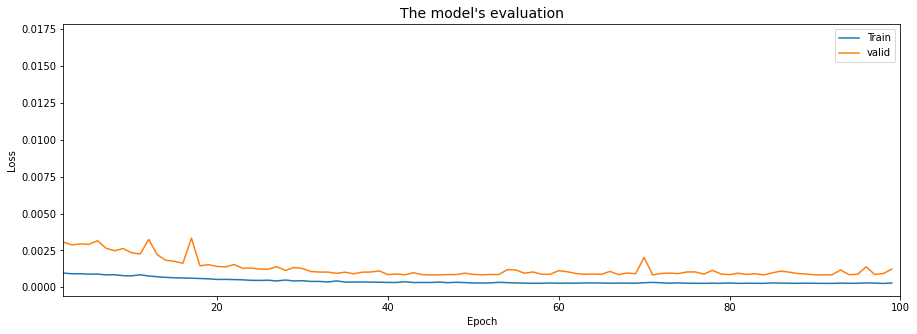

In [87]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train','valid'])
plt.title("The model's evaluation", fontsize=14)
plt.xlabel('Epoch')
plt.xlim(2,100)
plt.ylabel('Loss')
plt.savefig('LSTM_loss曲线')
plt.show()

In [88]:
#15天
y_pred_s = scaler.inverse_transform(model.predict(x_test_s))
y_test_s = scaler.inverse_transform(y_test_s.reshape(-1, 1))
y_pred_s.shape

(15, 1)

In [89]:
#30天
y_pred_m30 = scaler.inverse_transform(model.predict(x_test_m30))
y_test_m30 = scaler.inverse_transform(y_test_m30.reshape(-1, 1))
y_pred_m30.shape

(30, 1)

In [90]:
#60天
y_pred_m60 = scaler.inverse_transform(model.predict(x_test_m60))
y_test_m60 = scaler.inverse_transform(y_test_m60.reshape(-1, 1))
y_pred_m60.shape

(60, 1)

In [91]:
#180天
y_pred_l = scaler.inverse_transform(model.predict(x_test_l))
y_test_l = scaler.inverse_transform(y_test_l.reshape(-1, 1))
y_pred_l.shape

(180, 1)

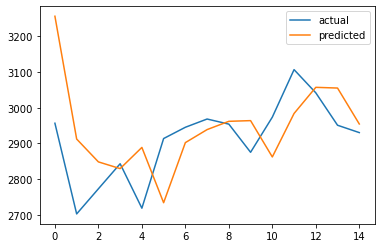

In [92]:
#15天
plt.plot(y_test_s, label = "actual")
plt.plot(y_pred_s, label = "predicted")
plt.legend()
plt.savefig("sh_predict15.png",dpi=600)
plt.show()

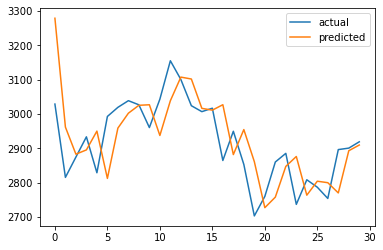

In [93]:
#30天
plt.plot(y_test_m30, label = "actual")
plt.plot(y_pred_m30, label = "predicted")
plt.legend()
plt.savefig("sh_predict30.png",dpi=600)
plt.show()

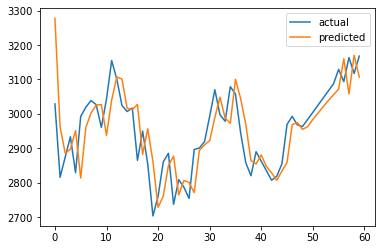

In [94]:
#60天
plt.plot(y_test_m60, label = "actual")
plt.plot(y_pred_m60, label = "predicted")
plt.legend()
plt.savefig("sh_predict60.png",dpi=600)
plt.show()

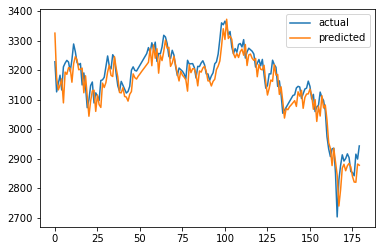

In [95]:
#180天
plt.plot(y_test_l, label = "actual")
plt.plot(y_pred_l, label = "predicted")
plt.legend()
plt.savefig("sh_predict180.png",dpi=600)
plt.show()

In [96]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [97]:
#15天
MAE = mean_absolute_error(y_test_s, y_pred_s)
MSE = mean_squared_error(y_test_s, y_pred_s)
rmse_score = math.sqrt(mean_squared_error(y_test_s,y_pred_s))
def mape(y_true_s, y_pred_s):
    return np.mean(np.abs((y_pred_s - y_true_s) / y_true_s))
print('MAPE:',mape(y_test_s, y_pred_s))
print('Root Mean Squared Error(test) : ',rmse_score)
print('The Mean Absolute Error is: {}'.format(MAE))
print('The Mean Squared Error is: {}'.format(MSE))
print('R-squared Score  : ',r2_score(y_test_s,y_pred_s))

MAPE: 0.03453701356098273
Root Mean Squared Error(test) :  129.0881451073985
The Mean Absolute Error is: 99.53163572227007
The Mean Squared Error is: 16663.74920726877
R-squared Score  :  -0.43209313821043227


In [98]:
#30天
MAE = mean_absolute_error(y_test_m30, y_pred_m30)
MSE = mean_squared_error(y_test_m30, y_pred_m30)
rmse_score = math.sqrt(mean_squared_error(y_test_m30,y_pred_m30))
def mape(y_true_m30, y_pred_m30):
    return np.mean(np.abs((y_pred_m30 - y_true_m30) / y_true_m30))
print('MAPE:',mape(y_test_m30, y_pred_m30))
print('Root Mean Squared Error(test) : ',rmse_score)
print('The Mean Absolute Error is: {}'.format(MAE))
print('The Mean Squared Error is: {}'.format(MSE))
print('R-squared Score  : ',r2_score(y_test_m30,y_pred_m30))

MAPE: 0.02623172643114622
Root Mean Squared Error(test) :  98.68250708720794
The Mean Absolute Error is: 76.1580635362959
The Mean Squared Error is: 9738.237205016845
R-squared Score  :  0.23970324512391905


In [99]:
#60天
MAE = mean_absolute_error(y_test_m60, y_pred_m60)
MSE = mean_squared_error(y_test_m60, y_pred_m60)
rmse_score = math.sqrt(mean_squared_error(y_test_m60,y_pred_m60))
def mape(y_true_m60, y_pred_m60):
    return np.mean(np.abs((y_pred_m60 - y_true_m60) / y_true_m60))
print('MAPE:',mape(y_test_m60, y_pred_m60))
print('Root Mean Squared Error(test) : ',rmse_score)
print('The Mean Absolute Error is: {}'.format(MAE))
print('The Mean Squared Error is: {}'.format(MSE))
print('R-squared Score  : ',r2_score(y_test_m60,y_pred_m60))

MAPE: 0.020725584034464006
Root Mean Squared Error(test) :  80.41118690280032
The Mean Absolute Error is: 60.97212622228684
The Mean Squared Error is: 6465.958979117087
R-squared Score  :  0.5068088995163833


In [100]:
#180天
MAE = mean_absolute_error(y_test_l, y_pred_l)
MSE = mean_squared_error(y_test_l, y_pred_l)
rmse_score = math.sqrt(mean_squared_error(y_test_l,y_pred_l))
def mape(y_true_l, y_pred_l):
    return np.mean(np.abs((y_pred_l - y_true_l) / y_true_l))
print('MAPE:',mape(y_test_l, y_pred_l))
print('Root Mean Squared Error(test) : ',rmse_score)
print('The Mean Absolute Error is: {}'.format(MAE))
print('The Mean Squared Error is: {}'.format(MSE))
print('R-squared Score  : ',r2_score(y_test_l,y_pred_l))

MAPE: 0.01057539409362256
Root Mean Squared Error(test) :  41.38736761007
The Mean Absolute Error is: 33.28875129774289
The Mean Squared Error is: 1712.9141976910714
R-squared Score  :  0.8774621513208746


In [101]:
#15天
def mape(y_true_s, y_pred_s):
    return np.mean(np.abs((y_pred_s - y_true_s) / y_true_s))
print('MAPE:',mape(y_test_s, y_pred_s))

MAPE: 0.03453701356098273


In [102]:
#30天
def mape(y_true_m30, y_pred_m30):
    return np.mean(np.abs((y_pred_m30 - y_true_m30) / y_true_m30))
print('MAPE:',mape(y_test_m30, y_pred_m30))

MAPE: 0.02623172643114622


In [103]:
#60天
def mape(y_true_m60, y_pred_m60):
    return np.mean(np.abs((y_pred_m60 - y_true_m60) / y_true_m60))
print('MAPE:',mape(y_test_m60, y_pred_m60))

MAPE: 0.020725584034464006


In [104]:
#180天
def mape(y_true_l, y_pred_l):
    return np.mean(np.abs((y_pred_l - y_true_l) / y_true_l))
print('MAPE:',mape(y_test_l, y_pred_l))

MAPE: 0.01057539409362256


In [308]:
'''
fig = make_subplots(rows=4, cols=1)
#15天
fig.add_trace(go.Scatter(x=test_set_s_0.date,
                         y=y_test_s,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=1, col=1)

fig.add_trace(go.Scatter(x=test_set_s_0.date,
                         y=y_pred_s,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=1, col=1)
#30天


fig.add_trace(go.Scatter(x=test_set_m30_0.date,
                         y=y_test_m30,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=test_set_m30_0.date,
                         y=y_pred_m30,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)
#60天


fig.add_trace(go.Scatter(x=test_set_m60_0.date,
                         y=y_test_m60,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=3, col=1)

fig.add_trace(go.Scatter(x=test_set_m60_0.date,
                         y=y_pred_m60,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=3, col=1)
#180天


fig.add_trace(go.Scatter(x=test_set_l_0.date,
                         y=y_test_l,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=4, col=1)

fig.add_trace(go.Scatter(x=test_set_l_0.date,
                         y=y_pred_l,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=4, col=1)


fig.show()
'''

"\nfig = make_subplots(rows=4, cols=1)\n#15天\nfig.add_trace(go.Scatter(x=test_set_s_0.date,\n                         y=y_test_s,\n                         name='Truth',\n                         marker_color='LightSkyBlue',\n                         showlegend=False), row=1, col=1)\n\nfig.add_trace(go.Scatter(x=test_set_s_0.date,\n                         y=y_pred_s,\n                         name='Prediction',\n                         marker_color='MediumPurple',\n                         showlegend=False), row=1, col=1)\n#30天\n\n\nfig.add_trace(go.Scatter(x=test_set_m30_0.date,\n                         y=y_test_m30,\n                         name='Truth',\n                         marker_color='LightSkyBlue',\n                         showlegend=False), row=2, col=1)\n\nfig.add_trace(go.Scatter(x=test_set_m30_0.date,\n                         y=y_pred_m30,\n                         name='Prediction',\n                         marker_color='MediumPurple',\n                         

# LSTM泛化能力研究

In [108]:
hs = pd.read_excel('hs_index.xlsx')
zz = pd.read_excel('zz_index.xlsx')
startup = pd.read_excel('startup_index.xlsx')
profit = pd.read_excel('profit_index.xlsx')

In [109]:
hs.timestamp=pd.to_datetime(hs.date,format='%Y-%m-%d')
hs.index=hs.timestamp
hs.drop('date',axis = 1, inplace = True)

zz.timestamp = pd.to_datetime(zz.date, format = '%Y-%m-%d')
zz.index=zz.timestamp
zz.drop('date',axis = 1, inplace = True)

startup.timestamp = pd.to_datetime(startup.date, format = '%Y-%m-%d')
startup.index=startup.timestamp
startup.drop('date',axis = 1, inplace = True)

profit.timestamp=pd.to_datetime(profit.date,format='%Y-%m-%d')
profit.index=profit.timestamp
profit.drop('date',axis = 1, inplace = True)

<ipython-input-109-97f9cf0eb1be>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  hs.timestamp=pd.to_datetime(hs.date,format='%Y-%m-%d')
<ipython-input-109-97f9cf0eb1be>:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  zz.timestamp = pd.to_datetime(zz.date, format = '%Y-%m-%d')
<ipython-input-109-97f9cf0eb1be>:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  startup.timestamp = pd.to_datetime(startup.date, format = '%Y-%m-%d')
<ipython-input-109-97f9cf0eb1be>:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  profit.tim

## 沪深300

In [110]:
hs_test_set = hs[2750:].iloc[:,0:]
print(len(hs_test_set))

127


In [111]:
hs_test_scaled_data = scaler.fit_transform(hs_test_set)
hs_close_test_scaled_data = scaler.fit_transform(np.array(hs_test_set['close']).reshape(-1,1))

In [112]:
hs_x_test, hs_y_test = [], []
for i in range(time_steps, len(hs_test_set)):
    hs_x_test.append(hs_test_scaled_data[i - time_steps:i])
    hs_y_test.append(hs_test_scaled_data[i,3])
hs_x_test, hs_y_test = np.array(hs_x_test), np.array(hs_y_test)
print(hs_y_test.shape)
print(hs_x_test.shape)

(120,)
(120, 7, 5)


In [113]:
hs_close_pred = model.predict(hs_x_test)
hs_close_pred

array([[0.789093  ],
       [0.8249775 ],
       [0.8356465 ],
       [0.7914746 ],
       [0.8736438 ],
       [0.8100484 ],
       [0.8227267 ],
       [0.7842224 ],
       [0.8365619 ],
       [0.8108671 ],
       [0.8290228 ],
       [0.87768877],
       [0.87166697],
       [0.86532545],
       [0.79060835],
       [0.7791898 ],
       [0.81690323],
       [0.7742936 ],
       [0.7460471 ],
       [0.75650144],
       [0.79003406],
       [0.7422669 ],
       [0.7791457 ],
       [0.77227324],
       [0.7141523 ],
       [0.80389225],
       [0.797327  ],
       [0.7916398 ],
       [0.8065712 ],
       [0.80573714],
       [0.7480725 ],
       [0.8053238 ],
       [0.8163674 ],
       [0.80729043],
       [0.8375225 ],
       [0.81020516],
       [0.7672821 ],
       [0.76098514],
       [0.75287086],
       [0.75681245],
       [0.76003677],
       [0.8155968 ],
       [0.7914896 ],
       [0.82864904],
       [0.90130866],
       [0.94737977],
       [0.90510577],
       [0.994

In [114]:
hs_y_pred = scaler.inverse_transform(hs_close_pred)
hs_y_pred

array([[4851.8057],
       [4891.278 ],
       [4903.014 ],
       [4854.425 ],
       [4944.8105],
       [4874.856 ],
       [4888.8022],
       [4846.4478],
       [4904.0205],
       [4875.7563],
       [4895.728 ],
       [4949.26  ],
       [4942.6357],
       [4935.66  ],
       [4853.472 ],
       [4840.9116],
       [4882.3965],
       [4835.526 ],
       [4804.4556],
       [4815.955 ],
       [4852.8403],
       [4800.297 ],
       [4840.864 ],
       [4833.3037],
       [4769.3716],
       [4868.0845],
       [4860.863 ],
       [4854.607 ],
       [4871.0312],
       [4870.114 ],
       [4806.6836],
       [4869.659 ],
       [4881.8066],
       [4871.8228],
       [4905.077 ],
       [4875.0283],
       [4827.8135],
       [4820.8867],
       [4811.9614],
       [4816.2974],
       [4819.8438],
       [4880.959 ],
       [4854.442 ],
       [4895.317 ],
       [4975.241 ],
       [5025.919 ],
       [4979.418 ],
       [5077.9565],
       [4994.933 ],
       [4991.8594],


In [115]:
hs_y_test = scaler.inverse_transform(hs_y_test.reshape(-1, 1))
hs_y_test

array([[4929.9409],
       [4936.1918],
       [4883.8369],
       [4940.1089],
       [4913.6123],
       [4932.1084],
       [4874.7753],
       [4922.7232],
       [4910.1846],
       [4928.0156],
       [4959.7254],
       [4979.5235],
       [4963.0984],
       [4898.1644],
       [4864.138 ],
       [4908.7701],
       [4890.6851],
       [4839.8457],
       [4821.1119],
       [4868.7419],
       [4842.3458],
       [4848.1795],
       [4846.7444],
       [4821.1925],
       [4898.6529],
       [4888.3749],
       [4882.3777],
       [4883.3206],
       [4885.7544],
       [4837.6185],
       [4890.0575],
       [4912.399 ],
       [4913.3457],
       [4916.6579],
       [4896.4416],
       [4860.1265],
       [4851.423 ],
       [4832.026 ],
       [4843.851 ],
       [4856.163 ],
       [4901.0175],
       [4892.6209],
       [4922.1015],
       [4995.9298],
       [5078.6901],
       [5055.1172],
       [5083.8007],
       [5049.6953],
       [5005.8991],
       [5034.7321],


In [116]:
MAE = mean_absolute_error(hs_y_test, hs_y_pred)
MSE = mean_squared_error(hs_y_test, hs_y_pred)
rmse_score = math.sqrt(mean_squared_error(hs_y_test,hs_y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)
print('The Mean Absolute Error is: {}'.format(MAE))
print('The Mean Squared Error is: {}'.format(MSE))
print('R-squared Score  : ',r2_score(hs_y_test,hs_y_pred))

Root Mean Squared Error(test) :  54.86707336858017
The Mean Absolute Error is: 42.922894036458345
The Mean Squared Error is: 3010.395740033159
R-squared Score  :  0.9550852438605117


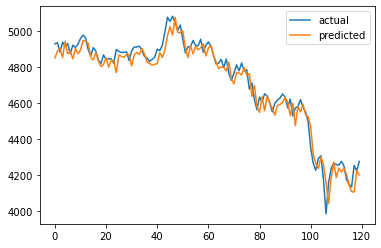

In [117]:
plt.plot(hs_y_test, label = "actual")
plt.plot(hs_y_pred, label = "predicted")
plt.legend()
plt.savefig("hs_predict.png",dpi=600)
plt.show()

## 中证

In [118]:
zz_test_set = zz[2750:].iloc[:,0:]
zz_test_scaled_data = scaler.fit_transform(zz_test_set)
zz_close_test_scaled_data = scaler.fit_transform(np.array(zz_test_set['close']).reshape(-1,1))

In [119]:
zz_x_test, zz_y_test = [], []
for i in range(time_steps, len(zz_test_set)):
    zz_x_test.append(zz_test_scaled_data[i - time_steps:i])
    zz_y_test.append(zz_test_scaled_data[i,3])
zz_x_test, zz_y_test = np.array(zz_x_test), np.array(zz_y_test)
print(zz_y_test.shape)
print(zz_x_test.shape)

(120,)
(120, 7, 5)


In [120]:
zz_close_pred = model.predict(zz_x_test)

In [121]:
zz_y_pred = scaler.inverse_transform(zz_close_pred)

In [122]:
zz_y_test = scaler.inverse_transform(zz_y_test.reshape(-1, 1))

In [123]:
MAE = mean_absolute_error(zz_y_test, zz_y_pred)
MSE = mean_squared_error(zz_y_test, zz_y_pred)
rmse_score = math.sqrt(mean_squared_error(zz_y_test,zz_y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)
print('The Mean Absolute Error is: {}'.format(MAE))
print('The Mean Squared Error is: {}'.format(MSE))
print('R-squared Score  : ',r2_score(zz_y_test,zz_y_pred))

Root Mean Squared Error(test) :  78.72230761053001
The Mean Absolute Error is: 58.404864687500016
The Mean Squared Error is: 6197.20171552691
R-squared Score  :  0.9440694866980739


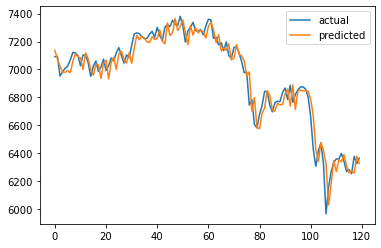

In [124]:
plt.plot(zz_y_test, label = "actual")
plt.plot(zz_y_pred, label = "predicted")
plt.legend()
plt.savefig("zz_predict.png",dpi=600)
plt.show()

## 创业板指数

In [125]:
startup_test_set = startup[2750:].iloc[:,0:]
startup_test_scaled_data = scaler.fit_transform(startup_test_set)
startup_close_test_scaled_data = scaler.fit_transform(np.array(startup_test_set['close']).reshape(-1,1))

In [126]:
startup_x_test, startup_y_test = [], []
for i in range(time_steps, len(startup_test_set)):
    startup_x_test.append(startup_test_scaled_data[i - time_steps:i])
    startup_y_test.append(startup_test_scaled_data[i,3])
startup_x_test, startup_y_test = np.array(startup_x_test), np.array(startup_y_test)
print(startup_y_test.shape)
print(startup_x_test.shape)

(120,)
(120, 7, 5)


In [127]:
startup_close_pred = model.predict(startup_x_test)

In [128]:
startup_y_pred = scaler.inverse_transform(startup_close_pred)

In [129]:
startup_y_test = scaler.inverse_transform(startup_y_test.reshape(-1, 1))

In [130]:
MAE = mean_absolute_error(startup_y_test, startup_y_pred)
MSE = mean_squared_error(startup_y_test, startup_y_pred)
rmse_score = math.sqrt(mean_squared_error(startup_y_test,startup_y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)
print('The Mean Absolute Error is: {}'.format(MAE))
print('The Mean Squared Error is: {}'.format(MSE))
print('R-squared Score  : ',r2_score(startup_y_test,startup_y_pred))

Root Mean Squared Error(test) :  47.853807630262345
The Mean Absolute Error is: 38.41301533854167
The Mean Squared Error is: 2289.9869047141547
R-squared Score  :  0.9748325831044253


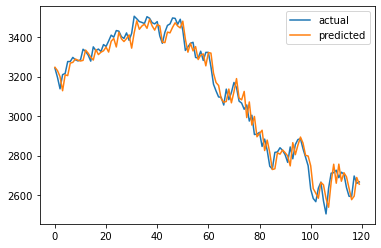

In [131]:
plt.plot(startup_y_test, label = "actual")
plt.plot(startup_y_pred, label = "predicted")
plt.legend()
plt.savefig("startup_predict.png",dpi=600)
plt.show()

## 红利

In [132]:
profit_test_set = profit[2750:].iloc[:,0:]
profit_test_scaled_data = scaler.fit_transform(profit_test_set)
profit_close_test_scaled_data = scaler.fit_transform(np.array(profit_test_set['close']).reshape(-1,1))

In [133]:
profit_x_test, profit_y_test = [], []
for i in range(time_steps, len(profit_test_set)):
    profit_x_test.append(profit_test_scaled_data[i - time_steps:i])
    profit_y_test.append(profit_test_scaled_data[i,3])
profit_x_test, profit_y_test = np.array(profit_x_test), np.array(profit_y_test)
print(profit_y_test.shape)
print(profit_x_test.shape)

(120,)
(120, 7, 5)


In [134]:
profit_close_pred = model.predict(profit_x_test)

In [135]:
profit_y_pred = scaler.inverse_transform(profit_close_pred)

In [136]:
profit_y_test = scaler.inverse_transform(profit_y_test.reshape(-1, 1))

In [137]:
MAE = mean_absolute_error(profit_y_test, profit_y_pred)
MSE = mean_squared_error(profit_y_test, profit_y_pred)
rmse_score = math.sqrt(mean_squared_error(profit_y_test,profit_y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)
print('The Mean Absolute Error is: {}'.format(MAE))
print('The Mean Squared Error is: {}'.format(MSE))
print('R-squared Score  : ',r2_score(profit_y_test,profit_y_pred))

Root Mean Squared Error(test) :  34.85072406129402
The Mean Absolute Error is: 25.64063294921875
The Mean Squared Error is: 1214.5729675964578
R-squared Score  :  0.8494369724506325


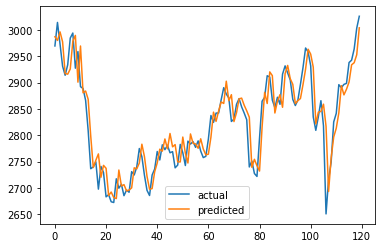

In [138]:
plt.plot(profit_y_test, label = "actual")
plt.plot(profit_y_pred, label = "predicted")
plt.legend()
plt.savefig("profit_predict.png",dpi=600)
plt.show()